In [33]:
class bresenham:
    def __init__(self, start, end):
        self.start = list(start)
        self.end = list(end)
        self.path = []
        self.steep = abs(self.end[1]-self.start[1]) > abs(self.end[0]-self.start[0])
        if self.steep:
            self.start = self.swap(self.start[0],self.start[1])
            self.end = self.swap(self.end[0],self.end[1])
        if self.start[0] > self.end[0]:
            _x0 = int(self.start[0])
            _x1 = int(self.end[0])
            self.start[0] = _x1
            self.end[0] = _x0
            _y0 = int(self.start[1])
            _y1 = int(self.end[1])
            self.start[1] = _y1
            self.end[1] = _y0
        dx = self.end[0] - self.start[0]
        dy = abs(self.end[1] - self.start[1])
        error = 0
        derr = dy/float(dx)
        ystep = 0
        y = self.start[1]
        if self.start[1] < self.end[1]: ystep = 1
        else: ystep = -1
        for x in range(self.start[0],self.end[0]+1):
            if self.steep:
                self.path.append((y,x))
            else:
                self.path.append((x,y))
            error += derr
            if error >= 0.5:
                y += ystep
                error -= 1.0
    def swap(self,n1,n2):
        return [n2,n1]
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy

def make_outline(path):
    img = cv2.imread(path)
    Points = []
    def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            xy = "%d,%d" % (x, y)
            Points.append([x,y])
            cv2.circle(img, (x,y), 1, (0, 0, 255), thickness=-1)
            cv2.imshow("image", img)
    cv2.namedWindow("image")
    cv2.setMouseCallback("image", on_EVENT_LBUTTONDOWN)
    cv2.imshow("image", img)
    cv2.waitKey(0)
    cv2.destroyWindow("image")
    return Points
def plot_line(K):
    print("The points you chose:")
    plt.scatter([i[0] for i in K],[i[1] for i in K])
    plt.show()
    Path = []
    K.append(K[0])
    for i in range(len(K)-1):
        Path.append(bresenham(K[i],K[i+1]).path)
    print("Line:")
    for P in Path:
        plt.scatter([i[0] for i in P],[i[1] for i in P])
    return Path

In [34]:
Source = cv2.imread("s.png")

The points you chose:


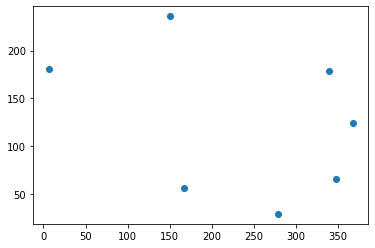

Line:


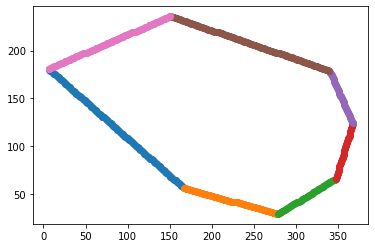

In [35]:
Outline = make_outline("s.png")
Out = plot_line(Outline)

The points you chose:


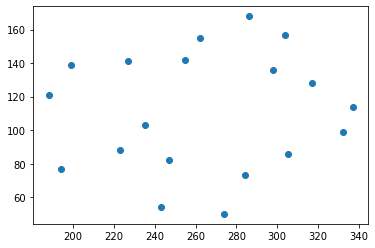

Line:


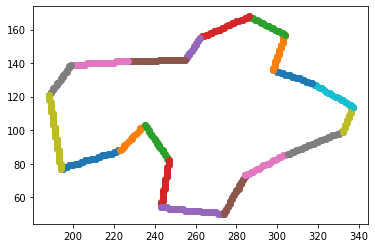

In [36]:
Innerline = make_outline("s.png")
Inner = plot_line(Innerline)

In [37]:
def Loss(Line,bias):
    Loss = []
    for i in range(len(Line)-1):
        Loss.append(cv2.norm(Source[Line[i][1]][Line[i][0]],Source[Line[i+1][1]][Line[i+1][0]]))
    return Loss

In [38]:
Out_loss = []
for Line in Out:
    Out_loss = Out_loss + Loss(Line,0)
k = np.mean(Out_loss)
k

1.1776799378527416

In [39]:
def dedu(Out):
    ALL = []
    for i in Out:
        ALL = ALL+i
    Fill = []
    for i in ALL:
        if i not in Fill:
            Fill.append(i)
    return Fill

In [40]:
Set_in = dedu(Inner)
len(Set_in)

443

In [41]:
Set_out = dedu(Out)
len(Set_out)

789

In [42]:
Start = Set_in[0]
End = Set_out[0]
distance = cv2.norm(Start,End)
for i in Set_in:
    for j in Set_out:
        d_temp = cv2.norm(i,j)
        if d_temp < distance:
            distance = d_temp
            Start = i
            End = j

In [43]:
Start_side = bresenham(Start,End).path

In [44]:
def sub(v1,v2):
    return [v1[0]-v2[0],v1[1]-v2[1]]

In [45]:
Direction = sub(Start_side[-1],Start_side[0])
Direction

[4, 15]

In [46]:
def cross_product(p1,p2):
    return p1[0]*p2[1]-p1[1]*p2[0]

In [47]:
def if_target(R,image,Direction,S):
    #if in graph
    #x 
    if R[0]>image.shape[1]:
        return False
    #y
    if R[1]>image.shape[0]:
        return False
    #means out of adjust range
    if np.array_equal(image[R[1]][R[0]],[255,0,0]) == False:
        return False
    if cross_product(Direction,sub(R,list(S)))<0:
        return False
    return True

In [48]:
def around4(S):
    return [(S[0]-1,S[1]),(S[0]+1,S[1]),(S[0],S[1]-1),(S[0],S[1]+1)]

In [49]:
def find_pair(S):
    Reach = around4(S)
    for i in Reach:
        if if_target(i,image,Direction,S):
            return i
    print("fair to pair " + str(S))
    return False

In [50]:
def get_pair_list(Search_edge):
    Pair = []
    for s in Search_edge:
        ans = find_pair(s)
        if ans:
            Pair.append(ans)
        else:
            print("Error,need drop")
            Pair.append("DE")
    return Pair

[(239, 39), (239, 40), (240, 41), (240, 42), (240, 43), (240, 44), (241, 45), (241, 46), (241, 47), (241, 48), (242, 49), (242, 50), (242, 51), (242, 52), (243, 53), (243, 54)]


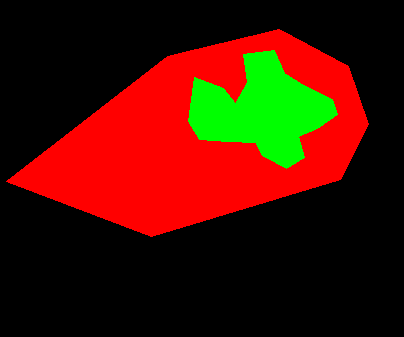

In [51]:
print(Start_side)
test = np.zeros(Source.shape, dtype=np.uint8)
image = test
O = np.int32([Outline])
I = np.int32([
    Innerline])
image = cv2.fillPoly(image,O,(255,0,0))
image = cv2.fillPoly(image,I,(0,255,0))
Image.fromarray(image)

In [52]:
for i in range(len(Start_side)):
    image[Start_side[i][1]][Start_side[i][0]] = [0,0,255]
Target_side = get_pair_list(Start_side)
Target_side = [tuple(n) for n in Target_side]
Target_side

[(238, 39),
 (238, 40),
 (239, 41),
 (239, 42),
 (239, 43),
 (239, 44),
 (240, 45),
 (240, 46),
 (240, 47),
 (240, 48),
 (241, 49),
 (241, 50),
 (241, 51),
 (241, 52),
 (242, 53),
 (242, 54)]

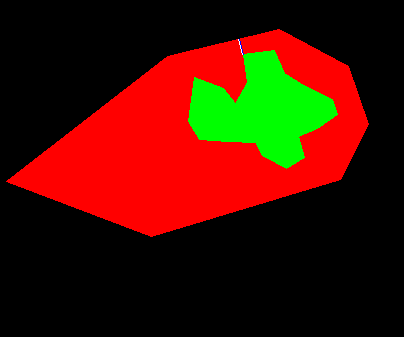

In [53]:
for i in range(len(Target_side)):
    if Target_side[i] != ('D','E'):
        image[Target_side[i][1]][Target_side[i][0]] = [255,255,255]
Image.fromarray(image)

In [54]:
def place_to_co(p):
    return [i[0] for i in p],[i[1] for i in p]

In [57]:
Node_dic = {}
ID = 0

In [58]:
for n in Start_side:
    Node_dic[n] = ID
    ID = ID + 1

In [59]:
for n in Target_side:
    Node_dic[n] = ID
    ID = ID + 1

In [60]:
Move_area = []
for x in range(image.shape[1]):
    for y in range(image.shape[0]):
        if np.array_equal(image[y][x],[255,0,0]):
            Node_dic[(x,y)] = ID
            Move_area.append((x,y))
            ID = ID + 1

In [61]:
def get_color(node,img):
    return img[node[1]][node[0]]
def get_edge(node1,node2,Source):
    return (Node_dic[node1],Node_dic[node2],cv2.norm(get_color(node1,Source),get_color(node2,Source)))

In [62]:
Edge = []
for S in Start_side:
    Reach = around4(S)
    for R in Reach:
        if np.array_equal(get_color(R,image),[255,0,0]):
            #Red is ok
            Edge.append(get_edge(S,R,Source))

In [63]:
for S in Target_side:
    Reach = around4(S)
    for R in Reach:
        if np.array_equal(get_color(R,image),[255,0,0]):
            #Red is ok
            Edge.append(get_edge(S,R,Source))

In [78]:
with open("task","w") as f:
    for i in range(len(Start_side)):
        s = str(Node_dic[Start_side[i]])+" "+str(Node_dic[Target_side[i]])
        print(s)
        f.write(s+"\n")

0 16
1 17
2 18
3 19
4 20
5 21
6 22
7 23
8 24
9 25
10 26
11 27
12 28
13 29
14 30
15 31


In [66]:
Normal_edge = []
for node in Move_area:
    #For normal red points, the edge connected to the cut have already added
    #so just consider the red-red edge
    Reach = around4(node)
    for R in Reach:
        #determine that Red-Red
        if np.array_equal(get_color(R,image),[255,0,0]):
            Normal_edge.append(get_edge(R,node,Source))

In [67]:
len(Normal_edge)

140260

In [68]:
Node_All = Start_side + Target_side + Move_area
Edge_All = Edge + Normal_edge
with open("Edge","w") as f:
    for line in Edge_All:
        f.write(str(line[0])+" "+str(line[1])+" "+("%.2f" % line[2])+"\n")

In [69]:
ID_dic = {v: k for k, v in Node_dic.items()}

In [72]:
def read_path_plot(path):
    with open(path) as f:
        p = f.read()
    path = p.split()
    pim = copy.deepcopy(image)
    enclose = []
    for i in path:
        p = ID_dic[int(i)]
        enclose.append(p)
        pim[p[1]][p[0]] = [100,220,220]
    Line = copy.deepcopy(enclose)
    Loss = []
    for i in range(len(Line)-1):
        Loss.append(cv2.norm(Source[Line[i][1]][Line[i][0]],Source[Line[i+1][1]][Line[i+1][0]]))
    print("sum:"+str(sum(Loss)))
    print("k:"+str(sum(Loss)/len(enclose)))
    plt.imshow(pim)
    return Image.fromarray(pim),enclose

sum:361.398668847661
k:0.3578204642056049


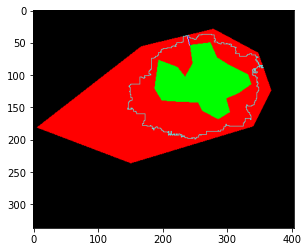

In [79]:
plot,enclose = read_path_plot("P/path2")

sum:352.0692415097504
k:0.3166090301346676


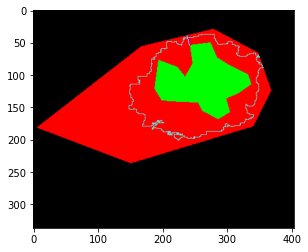

In [83]:
plot,enclose = read_path_plot("P/path4")